In [1]:
# Classificador 01
# importando o nltk
import nltk
import os
from modulos.file import getDirectories
from modulos.file import getFilesByType, cleaner
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [2]:
# Recupera a lista de subdiretórios do diretório datasource
folderList = getDirectories('datasource', 0)
folderList.remove('.ipynb_checkpoints')
folderList

['carlosDrumm', 'clariceLispec', 'manoelBand']

In [3]:
# concatenar todos os textos de cada autor de modo que só haja uma representação de texto por autor (abordagem de perfis)
perfil = {}
documentCount = 0
for folder in folderList:
    rootPath = 'datasource/' + folder
    paths = getFilesByType(rootPath, 'txt')
    
    textoFull = ''
    for file in paths:
        documentCount += 1
        currentPath = rootPath+'/'+file
        texto = open(currentPath, 'r', encoding='utf-8').read()
        textoFull = textoFull + texto + '\n'
    perfil[folder] = textoFull
    

#print(perfil['carlosDrumm'])
        

In [4]:
print('Total de documentos = ' ,documentCount)

Total de documentos =  47


In [5]:
from modulos.file import getDirectories
from modulos.utils import only_stopwords


In [6]:
# Drop tabela e recria
import psycopg2
try:
    conn = psycopg2.connect(host='localhost', database='tccii', user='postgres', password='123456')
    cursor = conn.cursor()
    droptable = 'drop table if exists resources'
    createtable = 'create table resources ( id serial, autor varchar(100), resourceSize integer, perfil text);'
    cursor.execute(droptable)
    cursor.execute(createtable)
    conn.commit()
    conn.close()
except Exception as e:
    print(e)

In [7]:
# Percorre cada perfil e remove toda palavra que não é uma stopword
import psycopg2
conn = psycopg2.connect(host='localhost', database='tccii', user='postgres', password='123456')
cursor = conn.cursor()
for p in perfil:
    perfil[p], size = only_stopwords(perfil[p])
    #print("insert into resources values (default, '" + p + "', " + str(size) + ", '" + perfil[p] +"')")
    sql = "insert into resources values (default, '" + p + "', " + str(size) + ", '" + perfil[p] +"')"
    cursor.execute(sql)
    conn.commit()
    print(p)
conn.close()

carlosDrumm
clariceLispec
manoelBand


In [8]:
import pandas as pd
import psycopg2
select = 'select autor, resourceSize, perfil from resources'
conn = psycopg2.connect(host='localhost', database='tccii', user='postgres', password='123456')
df =pd.read_sql_query(select, con = conn)
df.head

<bound method NDFrame.head of            autor  resourcesize  \
0    carlosDrumm           300   
1  clariceLispec           300   
2     manoelBand           300   

                                              perfil  
0  que que as não tem é sem que não quando o e na...  
1  me a de e e e de a de esse como uma com que eu...  
2  a das se ou eu tenha ou meu foi a com os seus ...  >

<Figure size 432x360 with 0 Axes>

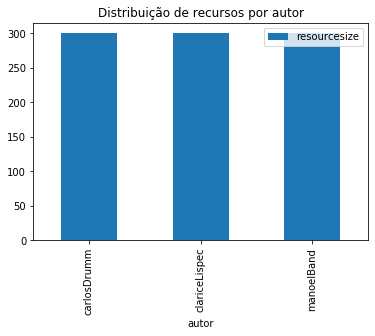

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,5))
df.groupby(by='autor').sum(axis=1, skipna=True).plot.bar(ylim=0, title='Distribuição de recursos por autor')
plt.show()

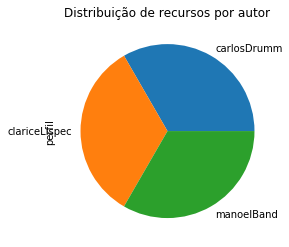

In [11]:
df.groupby('autor').perfil.count().plot.pie(title='Distribuição de recursos por autor')

In [12]:

import psycopg2
import pandas as pd


conn = psycopg2.connect(host='localhost', database='tccii', user='postgres', password='123456')
df = pd.read_sql_query("select * from resources",con=conn)

In [13]:
# Determina que o DataFrame terá apenas as colunas 'classe' e 'narrativa'

col = ['autor', 'perfil']
df = df[col]

df = df[pd.notnull(df['perfil'])] # Elimina linhas onde perfil seja null
df.columns = ['autor', 'perfil']
df['id'] = df['autor'].factorize()[0]
categoria_id_df = df[['autor', 'id']].drop_duplicates().sort_values('id')
categoria_para_id = dict(categoria_id_df.values)
id_para_categoria = dict(categoria_id_df[['id', 'autor']].values)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['perfil'], df['autor'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)
clfLSVC = LinearSVC().fit(X_train_tfidf, y_train)

In [17]:
# Manoel Bandeiras
texto ='Assim eu quereria o meu último poema. Que fosse terno dizendo as coisas mais simples e menos intencionais Que fosse ardente como um soluço sem lágrimas Que tivesse a beleza das flores quase sem perfume A pureza da chama em que se consomem os diamantes mais límpidos A paixão dos suicidas que se matam sem explicação.'
texto = only_stopwords(texto)[0]
print(texto)

print(clf.predict(count_vect.transform([texto])))
print(clfLSVC.predict(count_vect.transform([texto])))

eu o meu fosse as mais e fosse como um sem tivesse a das sem da em que se os mais dos que se sem
['carlosDrumm']
['carlosDrumm']


In [18]:
# Manoel Bandeiras
texto = 'Meu Quintana, os teus cantares Não são, Quintana, cantares: São, Quintana, quintanares.  Quinta-essência de cantares... Insólitos, singulares... Cantares? Não! Quintanares!  Quer livres, quer regulares, Abrem sempre os teus cantares Como flor de quintanares.  São cantigas sem esgares. Onde as lágrimas são mares De amor, os teus quintanares.  São feitos esses cantares De um tudo-nada: ao falares, Luzem estrelas luares.  São para dizer em bares Como em mansões seculares Quintana, os teus quintanares.  Sim, em bares, onde os pares Se beijam sem que repares Que são casais exemplares.  E quer no pudor dos lares. Quer no horror dos lupanares. Cheiram sempre os teus cantares  Ao ar dos melhores ares, Pois são simples, invulgares. Quintana, os teus quintanares.  Por isso peço não pares, Quintana, nos teus cantares... Perdão! digo quintanares.'
texto = only_stopwords(texto)[0]
print(texto)

print(clf.predict(count_vect.transform([texto])))
print(clfLSVC.predict(count_vect.transform([texto])))

os teus são de os teus de sem as são os teus esses um ao para em em os teus em os sem que são no dos no dos os teus dos são os teus isso não nos teus
['carlosDrumm']
['carlosDrumm']


In [27]:
# Manoel Bandeiras (usado para treinar o classificador)
texto = 'Chama e Fumo  Amor – chama, e, depois, fumaça… Medita no que vais fazer: O fumo vem, a chama passa… Gozo cruel, ventura escassa, Dono do meu e do teu ser, Amor – chama, e, depois, fumaça… Tanto ele queima! e, por desgraça, Queimando o que melhor houver, O fumo vem, a chama passa… Paixão puríssima ou devassa, Triste ou feliz, pena ou prazer, Amor – chama, e, depois, fumaça… A cada par que a aurora enlaça, Como é pungente o entardecer! O fumo vem, a chama passa… Antes, todo ele é gosto e graça. Amor, fogueira linha a arder! Amor – chama, e, depois, fumaça… Porquanto, mal se satisfaça (Como te poderei dizer?…), O fumo vem, a chama passa… A chama queima. O fumo embaça. Tão triste que é! Mas… tem de ser… Amor?… – chama, e, depois, fumaça: O fumo vem, a chama passa…'
texto = only_stopwords(texto)[0]
print(clf.predict(count_vect.transform([texto])))
print(clfLSVC.predict(count_vect.transform([texto])))


['carlosDrumm']
['carlosDrumm']


In [19]:
# Carlos Drummond
texto = 'Por que Deus permite que as mães vão-se embora? Mãe não tem limite, é tempo sem hora, luz que não apaga quando sopra o vento e chuva desaba, veludo escondido na pele enrugada, água pura, ar puro, puro pensamento. Morrer acontece com o que é breve e passa sem deixar vestígio. Mãe, na sua graça, é eternidade. Por que Deus se lembra - mistério profundo - de tirá-la um dia? Fosse eu Rei do Mundo, baixava uma lei: Mãe não morre nunca, mãe ficará sempre junto de seu filho e ele, velho embora, será pequenino feito grão de milho.'
texto = only_stopwords(texto)[0]
print(texto)
print(clf.predict(count_vect.transform([texto])))
print(clfLSVC.predict(count_vect.transform([texto])))

que que as não tem é sem que não quando o e na com o que é e sem na sua é que se de um eu do uma não de seu e ele será de
['clariceLispec']
['carlosDrumm']


In [23]:
# Clarisse Lispector (usado no treinamento)
texto = 'MEU DEUS, ME DÊ A CORAGEM Meu Deus, me dê a coragem de viver trezentos e sessenta e cinco dias e noites, todos vazios de Tua presença. Me dê a coragem de considerar esse vazio como uma plenitude. Faça com que eu seja a Tua amante humilde, entrelaçada a Ti em êxtase. Faça com que eu possa falar com este vazio tremendo e receber como resposta o amor materno que nutre e embala. Faça com que eu tenha a coragem de Te amar, sem odiar as Tuas ofensas à minha alma e ao meu corpo. Faça com que a solidão não me destrua. Faça com que minha solidão me sirva de companhia. Faça com que eu tenha a coragem de me enfrentar. Faça com que eu saiba ficar com o nada e mesmo assim me sentir como se estivesse plena de tudo. Receba em teus braços o meu pecado de pensar.'
texto = only_stopwords(texto)[0]
print(texto)
print(clf.predict(count_vect.transform([texto])))
print(clfLSVC.predict(count_vect.transform([texto])))

me a de e e e de a de esse como uma com que eu seja a a em com que eu com este e como o que e com que eu tenha a de sem as à minha e ao meu com que a não me com que minha me de com que eu tenha a de me com que eu com o e mesmo me como se estivesse de em teus o meu de
['clariceLispec']
['clariceLispec']


In [25]:
# Clarisse Lispecto( usado no treinamento)
texto = 'O que me tranquiliza é que tudo o que existe, existe com uma precisão absoluta. O que for do tamanho de uma cabeça de alfinete não transborda nem uma fração de milímetro além do tamanho de uma cabeça de alfinete. Tudo o que existe é de uma grande exatidão. Pena é que a maior parte do que existe com essa exatidão nos é tecnicamente invisível. O bom é que a verdade chega a nós como um sentido secreto das coisas. Nós terminamos adivinhando, confusos, a perfeição.'
texto = only_stopwords(texto)[0]
print(clf.predict(count_vect.transform([texto])))
print(clfLSVC.predict(count_vect.transform([texto])))

['clariceLispec']
['clariceLispec']
